# ECG Heartbeat Classification

- [ECG Heartbeat Classification: A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794)
- [MIT-BIH Arrhythmia Database](https://physionet.org/content/mitdb/1.0.0/)

In [3]:
# Libraries, Importing list

import numpy as np
np.random.seed(8580)

import pandas as pd
import matplotlib.pyplot as plt

import random

from scipy.signal import resample
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import math
from torch.optim.lr_scheduler import LambdaLR

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error #
from sklearn.preprocessing import label_binarize

import itertools


import os
path = './ecg_csv'
print(os.listdir(f'{path}'))

['mitbih_test.csv', 'ptbdb_abnormal.csv', 'ptbdb_normal.csv', 'mitbih_train.csv']


In [4]:
# Load CSV

import pandas as pd

df_train = pd.read_csv(f'{path}/mitbih_train.csv', header=None)
df_test = pd.read_csv(f'{path}/mitbih_test.csv', header=None)
df = pd.concat([df_train, df_test], axis=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


- MIT-BIH Arrhythmia Dataset에 기반하여 “5가지 유형”으로 분류한다.
    - 마지막 열의 숫자(0, 1, 2, 3, 4)가 **‘심박동(beat) 유형’**을 의미한다.  

 **5-Class 레이블 매핑**

| 숫자(Label)| 심박동 유형(이니셜)                 | 비고                          |
|:---------:|:-------------------------------:|:----------------------------|
|     0     | Normal (N)                      | 정상 박동 (정상 동성 리듬)        |
|     1     | Supra-ventricular premature (S) | 심실상 조기 박동                |
|     2     | Ventricular escape (V)          | 심실 탈출 박동 (PVC 등)         |
|     3     | Fusion of V and N (F)           | Fusion(정상 + 이소 박동의 혼합)  |
|     4     | Unknown/Unclassified (Q)        | 기타/분류 어려운 박동            |


In [6]:
# Labels

df[187].value_counts()

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64

정상 박동 데이터가 가장 많고, 정상 + 이소 박동의 혼합 데이터가 가장 적다.

In [7]:
# Extract Data from Matrix

M = df.values
X = M[:, :-1] # 마지막열을 제외한 모든 값
y = M[:, -1].astype(int) # 마지막열 값

In [8]:
# 불필요한 캐시 삭제
del df
del df_train
del df_test
del M

## Visual Input

In [9]:
# y에서 값이 0, 1, 2, 3, 4인 지점(인덱스들)을 각각 추출하여 별도의 변수(C0, C1, C2, C3, C4)에 저장

import numpy as np

X_orig = X.copy()
y_orig = y.copy()

C0 = np.argwhere(y_orig == 0).flatten()
C1 = np.argwhere(y_orig == 1).flatten()
C2 = np.argwhere(y_orig == 2).flatten()
C3 = np.argwhere(y_orig == 3).flatten()
C4 = np.argwhere(y_orig == 4).flatten()

# np.argwhere(y == 0)는 y 배열에서 값이 0인 모든 위치(인덱스) 를 찾아 2차원 배열로 반환. e.g. shape=(n,1).
# .flatten()을 통해 해당 2차원 배열을 1차원 배열로 만들어 [i1, i2, ...] 형태로 정리.
# 결국 C0에는 y가 0인 위치들의 인덱스, C1에는 1인 위치들의 인덱스, …, C4에는 4인 위치들의 인덱스가 각각 들어가게 된다.
# 따라서 y가 0~4 범주의 라벨을 가지는 분류 문제에서, 각 레이블별로 데이터 인덱스를 분류(또는 분할)하고자 할 때 쓸 수 있다.

In [10]:
C1

array([ 72471,  72472,  72473, ..., 106225, 106226, 106227])

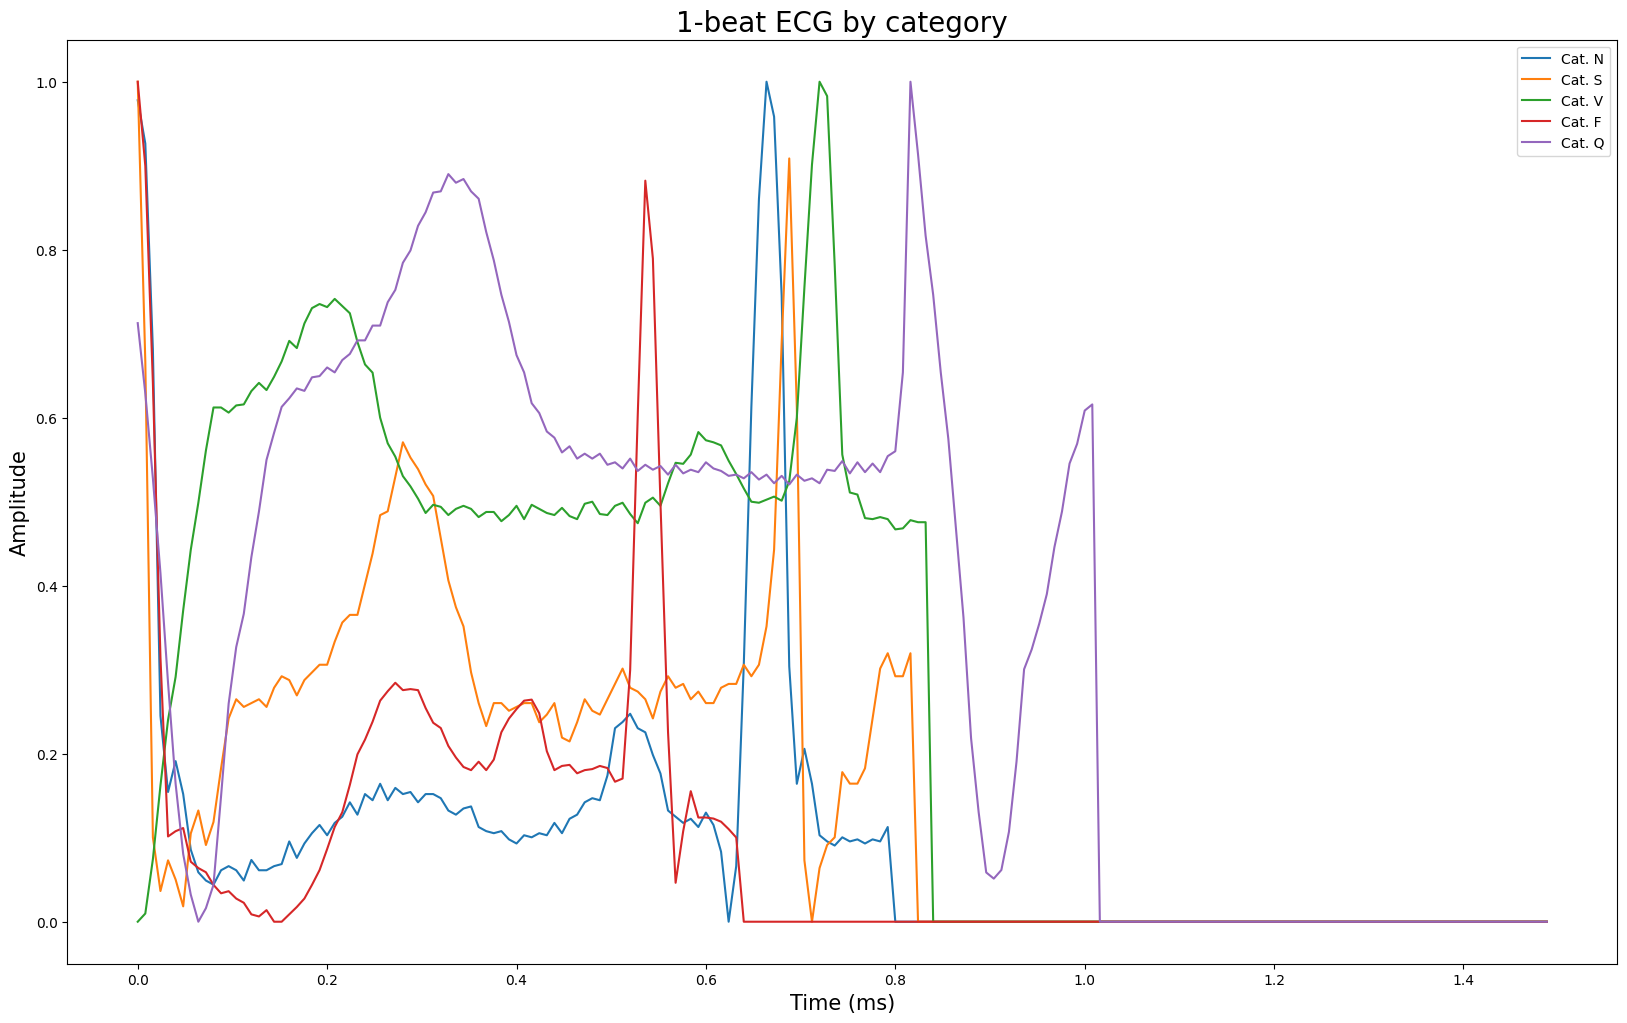

In [11]:
# 각 클래스별(0,1,2,3,4 → N,S,V,F,Q) 1-beat ECG Graph

import matplotlib.pyplot as plt

# Define x
# 총 187개의 시점(샘플 포인트), np.arange(0, 187): 0부터 186까지의 정수값.
# * 8/1000: 실제 시간축(millisec 단위) 적용. e.g. 샘플 간격 8ms, 187 포인트이면 대략 1.496초 정도.
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label="Cat. N")
plt.plot(x, X[C1, :][0], label="Cat. S")
plt.plot(x, X[C2, :][0], label="Cat. V")
plt.plot(x, X[C3, :][0], label="Cat. F")
plt.plot(x, X[C4, :][0], label="Cat. Q")
plt.legend()
plt.title("1-beat ECG by category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

## Data Augmentation

- 이전에 확인한 각 레이블 별 데이터 수를 통해, label 3의 데이터가 가장 적음을 알 수 있었다.
- 또한 정상 박동 데이터는 약 90,000 개로 다른 모든 데이터를 합한 것보다 더 많다.

- 따라서, 정상 박동 외 다르 레이블에 해당하는 박동 데이터 수를 증강하여 그 불균형을 해소하는 것을 목표로 한다.

In [12]:
import random

# ECG 신호(length 187)를 랜덤하게 확장 또는 축소, Time stretching.
def stretch(x):
  l = int(187 * (1 + (random.random()-0.5)/3)) # 약 155~219(± 17% 정도): 0~1 -> -0.5~+0.5 -> -0.17~+0.17 -> 0.83~1.17
  from scipy.signal import resample
  y = resample(x, l) # 원래 신호 x(187)를 새 길이(l)로 리샘플링
  if l < 187:
      y_ = np.zeros(shape=(187, )) # l < 187이면, y가 짧아지므로 나머지는 0으로 채움.
      y_[:l] = y
  else:
      y_ = y[:187] # l > 187이면, 그 초과 부분을 y[:187]로 잘라 187 길이로 맞춤.
  return y_


# 진폭(Amplitude)을 랜덤하게 변형(확대·축소)
def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha) # 일반적인 “배율만 곱하는(𝑥×𝑐) 것”이 아닌, 𝛼와 𝑥에 동시에 의존하는 가변 배율
    return x*factor
    # α가 양수/음수냐에 따라
    # 원래 𝑥값의 크기에 따라
    # 미묘하게 다른 진폭 변화를 생성(ECG를 무작위로 흔들어서 학습 다양성을 높이는 증강 효과를 노린 것이라 볼 수 있다.).

# range(len(result))로 4번 루프 돌아서 4개 증강 샘플 모두 생성.
# 한 번만 tmp = random.random()을 뽑고, if-elif-else로 3가지 증강 중 하나를 확실히 선택.
def augment(x):
    result = np.zeros(shape= (4, 187)) # 4개의 증강 버전을 담을 배열.
    for i in range(len(result)):       # 즉, i=0..3까지 4회 반복.
        tmp = random.random()          # 0~1 사이의 난수 추출 후 추출된 값에 해당하는 분기의 증강 수행.
        if tmp < 0.33:
            new_y = stretch(x)         # (1) 증강 : 길이를 확대 또는 축소
        elif tmp < 0.66:
            new_y = amplify(x)         # (2) 증강 : 진폭을 변형
        else:                          # (3) 증강 : (1) + (2)
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
    return result

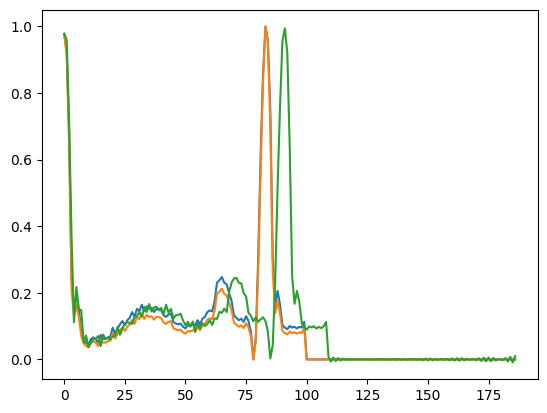

In [13]:
# 증강 적용 확인

plt.plot(X[0, :])
plt.plot(amplify(X[0, :]))
plt.plot(stretch(X[0, :]))
plt.show()

- 증강의 변화가 예상보다 변동성이 크지 않아, 다른 클래스를 정상 박동의 수까지 증강으로 만들 경우 과적합의 위험이 더 증가할 것으로 예상된다.
- 또한, 학습 시간에도 영향을 미칠 것으로 예상된다.

- 따라서, 0(정상)을 제외한 다른 레이블의 데이터 수를 맞추는 방식으로 증강한다.

In [14]:
augment_factors = {
    0: 0,
    1: 2,
    2: 0,
    3: 9,
    4: 0
}

for class_idx, factor in augment_factors.items():
    if factor <= 0:
        continue

    # 맵핑
    cindex = {
        0: C0,
        1: C1,
        2: C2,
        3: C3,
        4: C4
    }[class_idx]

    # "all_results"에 누적 후, 한 번에 연결 : 증강 데이터의 재증강 방지
    all_results = []
    for _ in range(factor):
        # np.apply_along_axis(augment, axis=1, arr=...) → (샘플수, 4, 187)
        result = np.apply_along_axis(augment, axis=1, arr=X_orig[cindex])
        # reshape → (샘플수*4, 187)
        result = result.reshape(-1, 187)
        all_results.append(result)

    merged_result = np.concatenate(all_results, axis=0)
    # New Label
    class_arr = np.ones((merged_result.shape[0],), dtype=int) * class_idx

    # 최종적으로 X, y에 이어붙이기
    X = np.vstack([X, merged_result])
    y = np.hstack([y, class_arr])

print("Done")
print("New X.shape:", X.shape)
print("New y.shape:", y.shape)


Done
New X.shape: (160586, 187)
New y.shape: (160586,)


## Train Test Split

In [15]:
# Random Sampling
# 가장 적은 클래스인 C3 데이터를 기준.

subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [16]:
# 랜덤 샘플링된 데이터를 테스트셋에 저장한 뒤 저장된 데이터는 학습 데이터에서 제거.

X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

del X
del y

In [17]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (157074, 187)
y_train (157074,)
X_test (4000, 187)
y_test (4000,)


In [18]:
print(X_train.dtype)
print(y_train.dtype)
print(X_test.dtype)
print(y_test.dtype)

float64
int64
float64
int64


## Preprocessing

In [19]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

In [20]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

y_train_oh = ohe.fit_transform(y_train.reshape(-1,1))  # 기본 반환이 sparse (csr_matrix)
y_test_oh  = ohe.transform(y_test.reshape(-1,1))

# 반드시 toarray() (또는 .A)로 밀집 변환해야 np.argmax가 정상 동작
y_train_oh = y_train_oh.toarray()  # shape (N, 5)
y_test_oh  = y_test_oh.toarray()


In [21]:
# (N, 5) → (N,)
y_train_int = np.argmax(y_train_oh, axis=1)  # 정수 라벨
y_test_int  = np.argmax(y_test_oh,  axis=1)

import torch

# (N,187,1) -> (N,1,187)
X_train_t = np.transpose(X_train, (0,2,1))
X_test_t  = np.transpose(X_test,  (0,2,1))

X_train_torch = torch.from_numpy(X_train_t).float()
X_test_torch  = torch.from_numpy(X_test_t).float()

y_train_torch = torch.from_numpy(y_train_int).long()  # (N,) 정수
y_test_torch  = torch.from_numpy(y_test_int).long()


# Modeling

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon MPS (GPU)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple Silicon MPS (GPU)


- Convolusion Network에 Skip Layer를 두어 신경망이 깊어져도 초기 원본을 일부 유지할 수 있도록 하는 Resnet의 형태를 하고 있다.
- 해당 논문에선 Tensorflow로 구현하였음을 언급하고 있으며, 마지막 손실함수로 Softmax를 거치지만, PyTorch는 해당 부분을 CrossEntropy 함수로 한 번에 수행하고, 평가를 위해서 따로 분리해야 하므로, 그렇게 진행하였다.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

class ResidualCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        # 초기 Conv
        self.conv_init = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0)

        # Block 5번 (각각 Conv -> ReLU -> Conv -> Add -> ReLU -> Pool)
        self.conv1_1 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.conv1_2 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.pool1   = nn.MaxPool1d(kernel_size=5, stride=2)

        self.conv2_1 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.conv2_2 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.pool2   = nn.MaxPool1d(kernel_size=5, stride=2)

        self.conv3_1 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.conv3_2 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.pool3   = nn.MaxPool1d(kernel_size=5, stride=2)

        self.conv4_1 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.conv4_2 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.pool4   = nn.MaxPool1d(kernel_size=5, stride=2)

        self.conv5_1 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.conv5_2 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.pool5   = nn.MaxPool1d(kernel_size=5, stride=2)

        # Flatten -> Dense(32) -> Dense(32) -> Dense(5)
        self.fc1 = nn.Linear(32, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, num_classes)

    def _res_block(self, x, conv1, conv2, pool):
        out = F.relu(conv1(x))
        out = conv2(out)
        out = out + x
        out = F.relu(out)
        out = pool(out)
        return out

    def forward(self, x):
        # x: (batch, 1, 187)
        x = self.conv_init(x)  # (batch, 32, 183)

        x = self._res_block(x, self.conv1_1, self.conv1_2, self.pool1)
        x = self._res_block(x, self.conv2_1, self.conv2_2, self.pool2)
        x = self._res_block(x, self.conv3_1, self.conv3_2, self.pool3)
        x = self._res_block(x, self.conv4_1, self.conv4_2, self.pool4)
        x = self._res_block(x, self.conv5_1, self.conv5_2, self.pool5)

        x = x.view(x.size(0), -1)
        # x[:, :32] -> (batch, 32)
        x = x[:, :32]

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)  # no softmax (CrossEntropyLoss)

        return logits


In [24]:
model = ResidualCNN(num_classes=5)
model.to(device) # Use GPU

ResidualCNN(
  (conv_init): Conv1d(1, 32, kernel_size=(5,), stride=(1,))
  (conv1_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool1): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool2): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool3): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4_2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool4): MaxPool1d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)

In [25]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_torch, y_train_torch)  # 반드시 정수 라벨!
test_dataset  = TensorDataset(X_test_torch,  y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=128, shuffle=False)

In [26]:
for i, (inputs, labels) in enumerate(train_loader):
    print("inputs shape:", inputs.shape)   # e.g. (128, 1, 187)
    print("labels shape:", labels.shape)   # e.g. (128,)
    print("labels dtype:", labels.dtype)   # e.g. torch.int64
    if i == 0:
        break


inputs shape: torch.Size([128, 1, 187])
labels shape: torch.Size([128])
labels dtype: torch.int64


In [27]:
import math
from torch.optim.lr_scheduler import LambdaLR

initial_lrate = 0.001
k = 0.75

# epoch 단위로: lr = initial_lr * exp(-k * epoch)
def lambda_epoch(epoch):
    return math.exp(-k * epoch)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lrate)
scheduler = LambdaLR(optimizer, lr_lambda=lambda_epoch)

In [28]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_batch = len(train_loader)

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)


        logits = model(inputs)     # (batch, 5)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Epoch이 끝날 때 스케줄러 업데이트
    scheduler.step()

    avg_loss = running_loss / total_batch
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, LR: {current_lr:.6f}")

Epoch [1/100] - Loss: 0.4841, LR: 0.000472
Epoch [2/100] - Loss: 0.2319, LR: 0.000223
Epoch [3/100] - Loss: 0.1806, LR: 0.000105
Epoch [4/100] - Loss: 0.1565, LR: 0.000050
Epoch [5/100] - Loss: 0.1440, LR: 0.000024
Epoch [6/100] - Loss: 0.1381, LR: 0.000011
Epoch [7/100] - Loss: 0.1352, LR: 0.000005
Epoch [8/100] - Loss: 0.1338, LR: 0.000002
Epoch [9/100] - Loss: 0.1330, LR: 0.000001
Epoch [10/100] - Loss: 0.1329, LR: 0.000001
Epoch [11/100] - Loss: 0.1327, LR: 0.000000
Epoch [12/100] - Loss: 0.1325, LR: 0.000000
Epoch [13/100] - Loss: 0.1327, LR: 0.000000
Epoch [14/100] - Loss: 0.1325, LR: 0.000000
Epoch [15/100] - Loss: 0.1324, LR: 0.000000
Epoch [16/100] - Loss: 0.1323, LR: 0.000000
Epoch [17/100] - Loss: 0.1323, LR: 0.000000
Epoch [18/100] - Loss: 0.1323, LR: 0.000000
Epoch [19/100] - Loss: 0.1324, LR: 0.000000
Epoch [20/100] - Loss: 0.1324, LR: 0.000000
Epoch [21/100] - Loss: 0.1324, LR: 0.000000
Epoch [22/100] - Loss: 0.1324, LR: 0.000000
Epoch [23/100] - Loss: 0.1323, LR: 0.0000

In [29]:
# model.eval()
# for inputs, labels in test_loader:
#     print("inputs:", inputs.dtype, inputs.device)
#     print("labels:", labels.dtype, labels.device)

#     # 모델의 첫 Conv 레이어 예시
#     print("model.conv1.weight:", model.conv1_1.weight.dtype, model.conv1_1.weight.device)

#     outputs = model(inputs)  # ← 여기서 에러 발생?
#     ...
#     break

In [30]:
model.eval()

correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        # 1) 모델 추론 (logits)
        outputs = model(inputs).cpu()

        # 2) 정확도 계산용 argmax
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # 3) 전체 예측 확률 수집용 softmax
        probs = F.softmax(outputs, dim=1)

        # 4) CPU로 옮겨서 넘파이 변환, 리스트에 누적
        all_preds.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# 정확도 출력
accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

# 예측 확률(y_pred)와 실제 라벨(y_test) 최종 합치기
y_pred = np.concatenate(all_preds, axis=0)
y_test = np.concatenate(all_labels, axis=0)

print("y_pred :", y_pred.shape)
print("y_test :", y_test.shape)

Validation Accuracy: 0.9267
y_pred : (4000, 5)
y_test : (4000,)


              precision    recall  f1-score   support

           0       0.82      0.98      0.89       800
           1       0.95      0.84      0.89       800
           2       0.98      0.86      0.92       800
           3       0.93      0.97      0.95       800
           4       0.99      0.97      0.98       800

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000

ranking-based average precision : 0.960
Ranking loss : 0.025
Coverage error : 1.098
Normalized confusion matrix


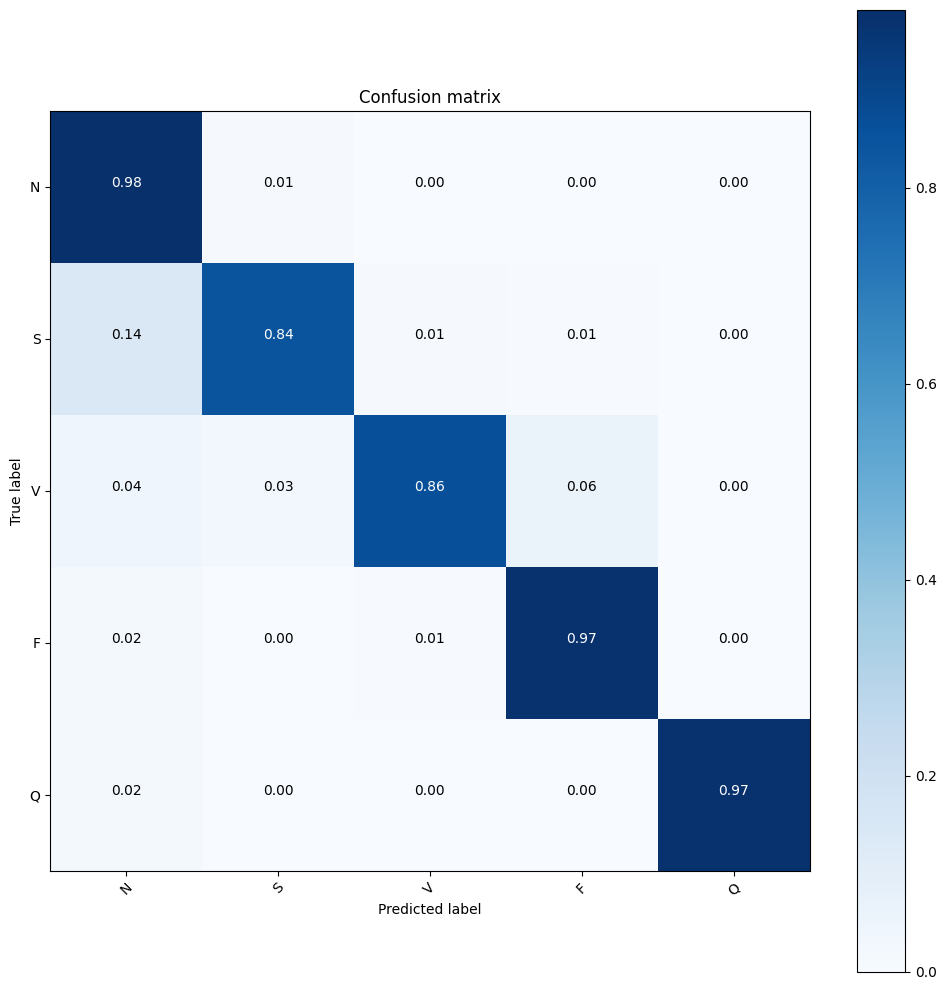

In [31]:
# 모델 추론 -> y_pred 확률 (N,5)
# y_test (N,) 정수 라벨

import numpy as np
from sklearn.metrics import (classification_report, confusion_matrix,
                             label_ranking_average_precision_score,
                             label_ranking_loss, coverage_error)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import itertools

# (1) 분류 리포트 & 혼동행렬
y_pred_cls = y_pred.argmax(axis=1)  # (N,) 예측 클래스
print(classification_report(y_test, y_pred_cls))

cnf_matrix = confusion_matrix(y_test, y_pred_cls)

# (2) rank-based metric
# y_test -> 원-핫
y_test_oh = label_binarize(y_test, classes=[0,1,2,3,4])  # shape (N,5)

print("ranking-based average precision : {:.3f}".format(
    label_ranking_average_precision_score(y_test_oh, y_pred)))
print("Ranking loss : {:.3f}".format(
    label_ranking_loss(y_test_oh, y_pred)))
print("Coverage error : {:.3f}".format(
    coverage_error(y_test_oh, y_pred)))

# (3) plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['N','S','V','F','Q'], normalize=True)
plt.show()